# Notebook 2.4.4: The Coffee Cooling Problem

---

<br>

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey, (License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/))

Revised, Mike Augspurger (2021-present)

<br>

---

Our problem is a classic modeling problem involving a cup of coffee.  You stop on the way to school to pick up a cup of coffee and a small container of milk. Assuming that you want the coffee to be as hot as possible when you arrive at work, should you add the milk at the coffee shop, wait until you get to school, or add the milk at some point in between?

## Implementing the Model

To get started, we'll focus on the coffee. Then, as an exercise, you can simulate the milk.

### Part 1: Creating a system object

As we did with our population simulations, we are going to pack our parameters and independent variables into a system dictionary.  

In [ ]:
# Initial coffee temp and the air temp, in degrees C
T_init = 90
T_env = 22

# Volume of coffee, in mL
volume = 300

# Heat transfer coefficient.  This is our initial guess at this value
r = 0.01

# The length of the simulation and of each time step, in minutes
t_end = 30
dt = 1.0

# Pack into a system dictionary
coffee = dict(T_init=T_init, T_env=T_env,
              volume=volume, r=r, t_end=t_end, dt=dt)

Remember that when we write `T_init = T_init`, we are assigning a global variable value (90 degrees in this case) to a variable that is local to the dictionary (`coffee['T_init`).

### Part 2: Creating a change function

Newton's law is a differential equation, which suggests continuous change.  But if we make `dt` small enough, we can *discretize* this equation and get decent results. So:

<br>

$$\frac{dT}{dt} = -r(T-T_{env})$$

<br>

becomes:

<br>

$$\frac{\Delta T}{\Delta t} = -r (T - T_{env})$$

<br>

where $\Delta t$ is the time step and $\Delta T$ is the change in temperature during that time step.  We can rearrange this to find the change in temperature during a time step:

<br>

$$\Delta T = -r (T - T_{env}) \Delta t$$

<br>

The following function takes the current time `t`, the current temperature, `T`, and a system object, and uses this equation to compute the change in temperature during a time step:

In [ ]:
def change_func(t, T, system):
    r, T_env, dt = system['r'], system['T_env'], system['dt']
    deltaT = -r * (T - T_env) * dt
    return deltaT

We can test it with the initial temperature of the coffee, like this:

In [ ]:
change_func(0, coffee['T_init'], coffee)

-0.68

With `dt=1` minute, the temperature drops by about 0.7 °C, at least for this value of `r`.  

---

<br>

🟨 🟨  Active reading: Matching  (Enter the letters in correct order, separated by a space)

In [ ]:
import pandas as pd
import numpy as np
from urllib.request import urlretrieve

location = 'https://github.com/MAugspurger/ModSimPy_MAugs/raw/main/'
folder = 'Support_files/'
name = 'Embedded_Qs.ipynb'
local, _ = urlretrieve(location + folder + name, name)
%run /content/$name

#@title { form-width: "50%", display-mode: "form" }
home = 'https://github.com/MAugspurger/ModSimPy_MAugs/raw/main/Images_and_Data/Embedded_Qs/'
data, number = display_match('2_4_DEQ', home,8)
answer = "" #@param {type:"string"}
a = answer.split(sep=" ")
check_match(data,a, number)

Look at the discretized equation for deltaT.  Which factors would cause the coffee to cool more quickly over the length of the simulation?

Terms

1) A larger time step dt
2) A higher T_env
3) A higher initial T_init
4) A larger r

Definitions

A) This will cause the coffee to cool more quickly
B) This will not cause the coffee to cool more quickly


---

### Part 3: Running a simulation

Here's a version of `run_simulation` that pulls in the system and the change function as arguments.  It simulates a series of time steps from until `t_end` is reached:

In [ ]:
def run_simulation(system, change_func):

    t_array = np.arange(0, system['t_end']+1, system['dt'])
    n = len(t_array)

    results = pd.Series(index=t_array,dtype=object)
    results.index.name = 'Time (m)'
    results.name = 'Temp (C)'
    results.iloc[0] = system['T_init']

    for i in range(n-1):
        t = t_array[i]
        T = results.iloc[i]
        results.iloc[i+1] = T + change_func(t, T, system)

    system['T_final'] = results.iloc[-1]
    return results

We've done a couple of new things here:

<br>

* we use `np.arange` to make an array of values from 0 to `t_end` with time step `dt`.  Unlike `np.linspace`, which takes an integer that indicates the number of points in the range, `arange` takes a step size that indicates the interval between values.

<br>

* When we make this results Series, we use the keyword argument `index` to indicate that the index of the `Series` is the array of time steps, `t_array`, even though we haven't added any data yet.  At this point, `results` looks like this:

<br>

<center>
<img src = https://github.com/MAugspurger/ModSimPy_MAugs/raw/main/Images_and_Data/Images/2_4/coffee_series.PNG width = 200>
</center>

<br>

* We use `iloc` (which stands for "index location") to specify the rows in the `results`.  We use this to identify a row in the `results` by index *number* (0,1,2, etc...) rather than the index label ("augie", "moline", "1951", "2015", etc...).  Why do this?  With `iloc`, the label in brackets is always an integer starting at 0.  So we can always get the first element with `iloc[0]` and the last element with `iloc[-1]`, regardless of what the labels are.

<br>

* The loop variable `i` is an integer that goes from 0 to `n-1`, including 0 but not including `n-1`.
So the first time through the loop, `i` is 0 and the value we add to the `results[i+1]` has index 1.
The last time through the loop, `i` is `n-2` and the value we add has index `n-1`--that is, the index of the last item in a `Series` with `n` elements.



We can run the simulation like this.  The result is a `Series` with one row per time step.
Here are the first few rows:

In [ ]:
results = run_simulation(coffee, change_func)
results.head()

Time (m)
0.0           90
1.0        89.32
2.0      88.6468
3.0    87.980332
4.0    87.320529
Name: Temp (C), dtype: object

And the final temperature:

In [ ]:
round(coffee['T_final'],1)

72.3

Finally, here's what the results for `coffee` looks like:

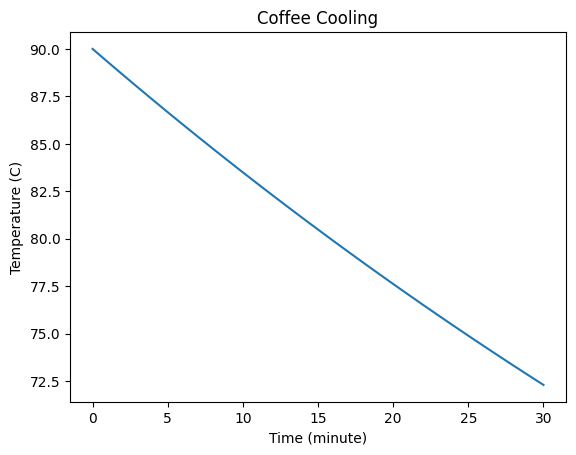

In [ ]:
results.plot(label='coffee', xlabel='Time (minute)',
         ylabel='Temperature (C)',
         title='Coffee Cooling');

---

<br>

🟨 🟨 Active reading

Add documentation to the `run_simulation` function, a line comment (#) for each of the 4 "sections" of the function.  Each comment should have its own line, and be above the section it is describing.

<br>

---

## Validating our Results

The temperature after 30 minutes is 72.3 °C.  Remember that when we did our investigation by driving to school with a cup of coffee, we had a final temperature of 70 °C.  So our value for `r` is a little too low: the coffee in the model is cooling more slowly than the coffee in the physical system.  This is a very simple validation procedure for our model.

<br>

---

## Exercises

---

<br>

🟨 🟨

### Exercise 1

The plot of the coffee cooling above looks linear.  Do you think it is linear?  Consider the governing differential equation $dTdt=−r(T−Tenv)$.  Comment on what will happen to the slope of the temperature plot as the coffee cools.

✅ ✅ Put your answer here

---


<br>

🟨 🟨

### Exercise 2

We simulated the cooling of the coffee: now simulate the warming of the milk.

<br>

Simulate the temperature of 50 mL of milk with a starting temperature of 5 °C, in a vessel with `r=0.1`, for 15 minutes, and plot the results. Make a `System` object that represents the milk, and use `run_simulation` to simulate it.
By trial and error, find a value for `r` that makes the final temperature close to 20 °C.

<br> Notice that we did all of this for the coffee above--so much of the code will look very similar.

In [ ]:
# Make the milk system

In [ ]:
# Run the simulation and plot it
